http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf

# 크롤링을 통한 이미지 분석 및 CAM

`-` Class Activation Mapping (CAM)은 설명가능한 인공지능모형 (eXplainable Artificial Intelligence, XAI) 중 하나로 CNN의 판단근거를 시각화하는 기술

In [2]:
import torch 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
from fastai.vision.all import *

## 크롤링

In [3]:
# 크롤링에 필요한 준비작업들
!pip install -Uqq duckduckgo_search
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastcore.all import *
def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 12.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [4]:
# 폴더만드는코드

# !rm -r images
!mkdir images
!mkdir images/train
!mkdir images/test 
!mkdir images/train/hanhyojoo
!mkdir images/train/jungwoosung
!mkdir images/test/hanhyojoo
!mkdir images/test/jungwoosung

In [5]:
#train
download_images(dest='./images/train/hanhyojoo',urls=search_images('hanhyojoo',max_images=200))
time.sleep(10) # 서버과부하를 위한 휴식코드 
download_images(dest='./images/train/jungwoosung',urls=search_images('jungwoosung',max_images=200))
time.sleep(10) # 서버과부하를 위한 휴식코드 
download_images(dest='./images/train/hanhyojoo',urls=search_images('hanhyojoo korea',max_images=200))
time.sleep(10) # 서버과부하를 위한 휴식코드 
download_images(dest='./images/train/jungwoosung',urls=search_images('jungwoosung kpop',max_images=200))
time.sleep(10) # 서버과부하를 위한 휴식코드

#test
download_images(dest='./images/test/hanhyojoo',urls=search_images('hanhyojoo photo',max_images=50))
time.sleep(10) # 서버과부하를 위한 휴식코드 
download_images(dest='./images/test/jungwoosung',urls=search_images('jungwoosung photo',max_images=50))
time.sleep(10) # 서버과부하를 위한 휴식코드

In [6]:
# 불량 이미지 삭제
bad_images = verify_images(get_image_files('./images'))
bad_images

# 불량 이미지 목록
bad_images.map(Path.unlink)
# 불량 이미지는 dls를 불러올 때 방해되므로 제거

(#21) [None,None,None,None,None,None,None,None,None,None...]

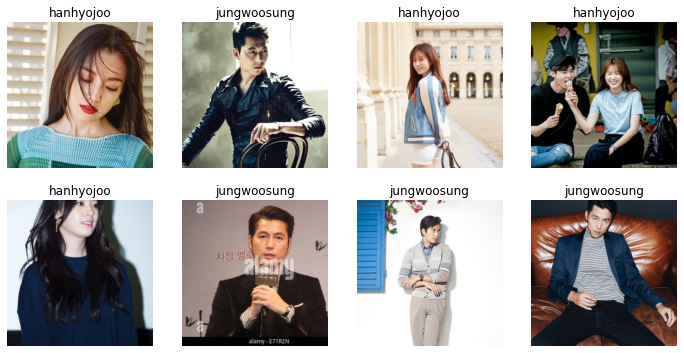

In [13]:
# dls 생성
dls = ImageDataLoaders.from_folder(path = './images', train='train',valid='test',item_tfms=Resize(512),bs=8)
dls.show_batch()

In [8]:
# 학습
lrnr = vision_learner(dls,resnet34,metrics=accuracy) 
lrnr.fine_tune(1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.516318,0.112931,0.947368,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.337922,0.028757,0.989474,00:27


`-` net2의 순서 바꾸기 전 전체 네트워크:

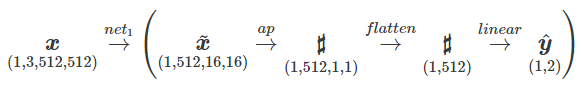

`-` 아래와 같이 순서를 변경!

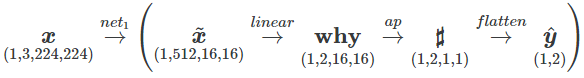

`-` 통찰: 이 경우 특이하게도 레이어의 순서를 바꿨을때 출력이 동일함 (선형변환하고 평균내거나 평균내고 선형변환하는건 같으니까)

`-` why 부분을 관찰해봄으로써 CNN의 판단 근거를 시각화 해볼 수 있다.

In [9]:
# 모형의 판단 근거를 시각화

net1= lrnr.model[0]
net2= lrnr.model[1]

net2= torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), # (64,512,16,16) -> (64,512,1,1) 
    torch.nn.Flatten(), # (64,512,1,1) -> (64,512) 
    torch.nn.Linear(512,2,bias=False) # (64,512) -> (64,2) 
)

net = torch.nn.Sequential(
    net1,
    net2
)

lrnr2= Learner(dls,net,metrics=accuracy)
lrnr2.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.619096,1.783440,0.442105,00:27


epoch,train_loss,valid_loss,accuracy,time
0,0.596286,1.617061,0.621053,00:25
1,0.591594,1.632929,0.684211,00:25
2,0.587477,0.792731,0.842105,00:26
3,0.526136,0.374602,0.873684,00:25
4,0.567817,0.592866,0.747368,00:25
5,0.533713,0.346253,0.863158,00:28
6,0.506746,0.348981,0.863158,00:25
7,0.468918,0.268951,0.905263,00:26
8,0.438686,0.259258,0.915789,00:26
9,0.377304,0.243483,0.926316,00:26


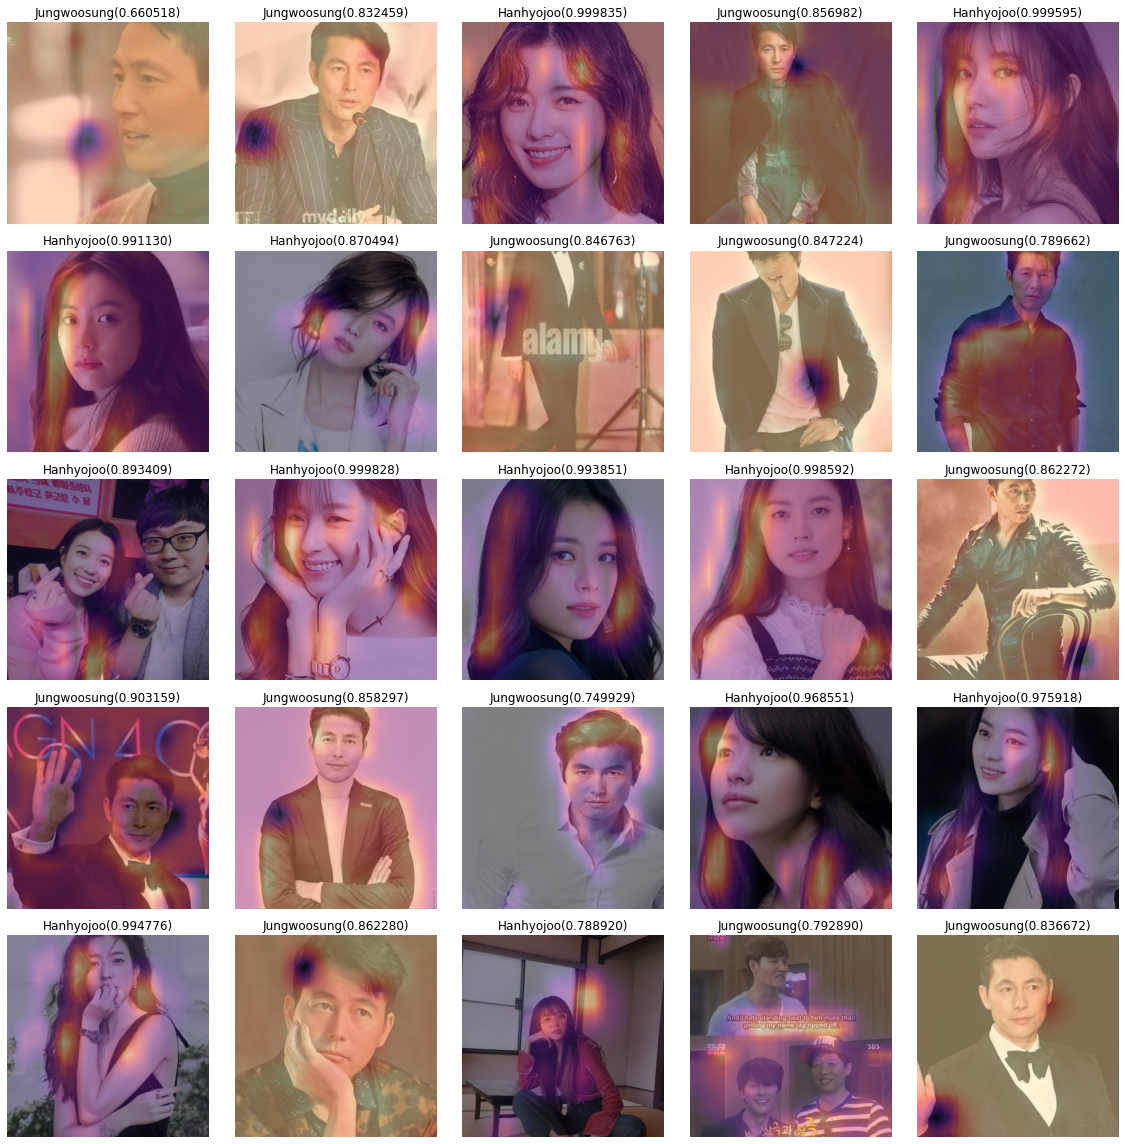

In [10]:
sftmax = torch.nn.Softmax(dim=1)

fig, ax = plt.subplots(5,5) 
path = './images'
imglen = len(get_image_files(path))

for i in range(5):
    for j in range(5): 
        k = np.random.randint(0, imglen)

        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
        why_han = why[0,0,:,:] 
        why_jung = why[0,1,:,:] 
        hanprob, jungprob = sftmax(net(x))[0][0].item(), sftmax(net(x))[0][1].item()
        if hanprob>jungprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_han.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("Hanhyojoo(%2f)" % hanprob)
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_jung.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("Jungwoosung(%2f)" % jungprob)

fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()